In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import tensorflow_privacy
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy
from tensorflow.keras.regularizers import L1,L2
from tensorflow.keras import layers
from keras import backend as K
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
tf.random.set_seed(42)

In [2]:
train, test = tf.keras.datasets.mnist.load_data()
train_data, train_labels = train
test_data, test_labels = test

train_data = np.array(train_data, dtype=np.float32)/255
test_data = np.array(test_data, dtype=np.float32)/255

train_data = train_data.reshape(train_data.shape[0],28,28,1) # angka 1 dibelakang menunjukkan color channel. Hanya ada 1 color channel
test_data = test_data.reshape(test_data.shape[0],28,28,1)

train_labels = np.array(train_labels, dtype = np.int32)
test_labels = np.array(test_labels, dtype = np.int32)

train_labels = tf.keras.utils.to_categorical(train_labels, num_classes = 10)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes = 10)

#check data distribution, normalized since divided by 255
assert train_data.min() == 0
assert train_data.max() == 1
assert test_data.min() == 0
assert test_data.max() == 1

## Defining Functions

In [3]:
def dp_sgd(l2_norm_clip,noise_multiplier,num_microbatches,learning_rate):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(16,8,
                              strides = 2,
                              padding = 'same',
                              activation = 'relu',
                              input_shape = (28,28,1)),
        tf.keras.layers.MaxPool2D(2,1),
        tf.keras.layers.Conv2D(32,4,
                               strides = 2,
                               padding = 'valid',
                               activation = 'relu'),
        tf.keras.layers.MaxPool2D(2,1),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(32, activation = 'relu'),
        tf.keras.layers.Dense(10, activation = 'softmax')
    ])
    
    optimizer = tensorflow_privacy.DPKerasSGDOptimizer(
        l2_norm_clip = l2_norm_clip,
        noise_multiplier = noise_multiplier,
        num_microbatches = num_microbatches,
        learning_rate = learning_rate)
    loss = tf.keras.losses.CategoricalCrossentropy(
        from_logits = False, reduction = tf.losses.Reduction.NONE)
    model.compile(optimizer = optimizer , loss = loss, metrics = ['accuracy'])
    return model

def getlayeroutput(model,data,index):
    from keras import backend as K
    getoutput = K.function([model.layers[0].input],[model.layers[index].output])
    return getoutput([data])[0]

def discriminator(in_shape):
    #model = tf.keras.Sequential([
    #    tf.keras.layers.Dense(in_shape*1.25,input_dim = in_shape,
    #                          activation = 'relu',
    #                          kernel_regularizer = L1(0.01),
    #                          bias_regularizer = L2(0.01)),
    #    tf.keras.layers.Dropout(0.2),
    #    tf.keras.layers.Dense(in_shape*2,input_dim = in_shape,activation = 'relu'),
    #    tf.keras.layers.Dense(in_shape*1.5,
    #                          activation = 'relu',
    #                          kernel_regularizer = L1(0.01),
    #                          bias_regularizer = L2(0.01)),
    #    tf.keras.layers.Dropout(0.2),
    #    tf.keras.layers.Dense(1,activation = 'sigmoid')
    #])
    model = tf.keras.Sequential([
        #tf.keras.layers.Dense(in_shape,input_dim = in_shape,
        #                      activation = None),       
        #tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(in_shape, input_dim = in_shape,
                              activation = 'relu'),
        tf.keras.layers.Dense(1,activation = 'sigmoid')
    ])
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 0.001,
    decay_steps = 50,
    decay_rate = 0.9,
    staircase = True)
    optimizer = tf.keras.optimizers.Adam(learning_rate = lr_schedule)
    model.compile(loss = 'binary_crossentropy',
                  optimizer = optimizer,
                  metrics = 'accuracy')
    return model

def discriminatortrue(in_shape):
    #model = tf.keras.Sequential([
    #    tf.keras.layers.Dense(in_shape,input_dim = in_shape,
    #                          activation = 'linear',
    #                          kernel_regularizer = L1(0.01),
    #                          bias_regularizer = L2(0.01),
    #                          kernel_initializer = 'uniform'),
    #    tf.keras.layers.Dropout(0.4),
    #    tf.keras.layers.Dense(1,activation = 'sigmoid')
    #])
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(in_shape,input_dim = in_shape,
                              activation = 'linear'),
        tf.keras.layers.Dense(1,activation = 'sigmoid')
    ])
    optimizer = tf.keras.optimizers.Adam()
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer,
                 metrics = 'accuracy')
    return model

def generator(in_shape):
    model = tf.keras.Sequential([
        #tf.keras.layers.Dense(16,input_dim = in_shape),
        tf.keras.layers.Conv1D(16,2,activation='linear'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Conv1D(32,2,activation='linear'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Conv1D(64,2,activation='linear'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(in_shape,activation='relu')
    ])
    return model

def GAN(gen,dis):
    dis.trainable = False
    model = tf.keras.Sequential([ 
        gen,
        dis
    ])
    opt = tf.keras.optimizers.Adam()
    model.compile(loss='binary_crossentropy',optimizer=opt)
    
    return model

def generate_fake_samples(gen, data, batch):
    x_input = np.random.randn(batch,data.shape[1])
    x_input = np.expand_dims(x_input, axis=2)
    x = gen.predict(x_input)
    y = np.zeros((batch,1))
    
    return x.reshape(batch,data.shape[1]),y

def shuffledata(xdata,ydata):
    indices = tf.range(start=0,limit=tf.shape(xdata)[0], dtype = tf.int32)
    idx = tf.random.shuffle(indices)
    return tf.gather(xdata,idx) , tf.gather(ydata,idx)

def train(gen, dis, distrue, gan, output_noise, output_true, n_epochs= 10000, n_batch = 512):
    #determine half the size of one batch, for updating the discriminator
    half_batch = int(n_batch/2)
    dishist=[]
    genhist=[]
    disacchist = []
    distrueacchist = []
    
    ### HUGE NOTE: Normalmodel is 1, DPmodel is 0
    
    #train the true discriminator to the DPmodel and Normalmodel data
    distrue_output_true_train_x = output_true[:] #setting x data from normalmodel for true discriminant
    distrue_output_true_train_y = np.ones((output_true.shape[0],1)) #setting y data from normalmodel for true discriminant
    
    distrue_output_noise_train_x = output_noise[:] #setting x data from DPmodel for true discriminant
    distrue_output_noise_train_y = np.zeros((output_noise.shape[0],1)) #setting y data from DPmodel for true discriminant
    
    #combine
    distruex = pd.DataFrame(distrue_output_true_train_x).append(pd.DataFrame(distrue_output_noise_train_x),ignore_index = True).to_numpy()
    distruey = pd.DataFrame(distrue_output_true_train_y).append(pd.DataFrame(distrue_output_noise_train_y),ignore_index = True).to_numpy()
    
    #shuffle
    distruex_shuffle, distruey_shuffle = shuffledata(distruex,distruey)
    distrue.fit(distruex_shuffle,distruey_shuffle)
    
    #manually enumerate epochs
    for epoch in range(n_epochs):
        ###########################################################################################################      
        ##GAN PART
        #prepare samples      
        #Normalmodel data
        x_real = output_true[np.random.choice(output_true.shape[0], half_batch, replace=False), :]
        y_real = np.ones((half_batch,1))
        
        #Normalmodel data upsampled (fake)
        x_fake, y_fake = generate_fake_samples(gen, output_true, half_batch)
        
        #combined
        disx = pd.DataFrame(x_real).append(pd.DataFrame(x_fake),ignore_index = True).to_numpy()
        disy = pd.DataFrame(y_real).append(pd.DataFrame(y_fake),ignore_index = True).to_numpy()
        
        #shuffle
        disx_shuffle, disy_shuffle = shuffledata(disx,disy)
        
        #update discriminator
        disloss, disacc = dis.train_on_batch(disx_shuffle,disy_shuffle)
        
        #input for gan
        noise = np.random.randn(n_batch,output_true.shape[1])
        noise = np.expand_dims(noise, axis=2)
        y_gen = np.ones((n_batch,1))
        
        #update generator from discriminator error
        gen_loss_fake = gan.train_on_batch(noise,y_gen)
        
        ###########################################################################################################
        ##TRUE DISCRIMINANT PART
        #Check the true discriminator performance
        #Normalmodel data upsampled (fake)
        distrue_output_true_x = x_fake[:]
        distrue_output_true_y = y_fake[:]
        distrue_output_true_y[:] = 1
    
        #DPmodel data
        distrue_output_noise_x = output_noise[np.random.choice(output_noise.shape[0], half_batch, replace=False), :]
        distrue_output_noise_y = np.zeros((distrue_output_true_y.shape[0],0))
        
        #aggregated
        distruex_test = pd.DataFrame(distrue_output_true_x).append(pd.DataFrame(distrue_output_noise_x),ignore_index = True).to_numpy()
        distruey_test = pd.DataFrame(distrue_output_true_y).append(pd.DataFrame(distrue_output_noise_y),ignore_index = True).to_numpy()
        
        
        distrueloss, distrueacc = distrue.test_on_batch(distruex_test,distruey_test)
        
        print('>%d, discriminant_loss=%.3f discriminant_acc=%.3f generator_loss=%.3f true_discriminant_acc=%.3f' % (epoch+1, disloss, disacc, gen_loss_fake, distrueacc))
        
        dishist.append(disloss)
        genhist.append(gen_loss_fake)
        disacchist.append(disacc)
        distrueacchist.append(distrueacc)
    plot_history(dishist,genhist,disacchist,distrueacchist)
    
    #final accuracy of True Discriminant
    output_true_upsampled_x, output_true_upsampled_y = generate_fake_samples(gen, output_true, output_true.shape[0])
    output_true_upsampled_y[:] = 1
    
    output_noise_x, output_noise_y = output_noise[:], np.zeros((output_noise.shape[0],1))
    
    distruex_final = pd.DataFrame(output_true_upsampled_x).append(pd.DataFrame(output_noise_x),ignore_index = True).to_numpy()
    distruey_final = pd.DataFrame(output_true_upsampled_y).append(pd.DataFrame(output_noise_y),ignore_index = True).to_numpy()
    
    #shuffle
    distruex_final_shuffle, distruey_final_shuffle = shuffledata(distruex_final,distruey_final)
    
    fin_loss, fin_acc = distrue.test_on_batch(distruex_final_shuffle, distruey_final_shuffle)
    
    print("Final True Discriminant Accuracy: %.3f" % fin_acc)
        
        
def plot_history(d_hist, g_hist, dacc_hist, dacc2_hist):
    # plot loss    
    plt.figure(1)
    plt.subplot(211)
    plt.plot(d_hist, label='discriminator_loss')
    plt.plot(g_hist, label='generator_loss')
    plt.legend()
    plt.xlabel('Epochs')
    plt.subplot(212)
    plt.plot(dacc_hist, label='GAN_discriminator_accuracy')
    plt.plot(dacc2_hist, label='True_discriminator_accuracy')
    plt.legend()
    plt.xlabel('Epochs')
    plt.show()
    plt.close()

## Training Original Model 

##### DPmodel & Normalmodel

In [4]:
DPmodel = dp_sgd(l2_norm_clip = 1.5, noise_multiplier = 1, 
                 num_microbatches = 50, learning_rate = 0.25)
Normalmodel = dp_sgd(l2_norm_clip = 1.5, noise_multiplier = 1, 
                 num_microbatches = 50, learning_rate = 0.25)

DPmodel.fit(train_data, train_labels, 
            epochs = 5, batch_size = 250,
            validation_data = (test_data, test_labels))

Normalmodel.fit(train_data, train_labels, 
                epochs = 5, batch_size = 250,
                validation_data = (test_data, test_labels))

Epoch 1/5
240/240 [==============================] - 31s 111ms/step - loss: 0.7557 - accuracy: 0.7639 - val_loss: 0.3790 - val_accuracy: 0.9069
Epoch 2/5
240/240 [==============================] - 27s 113ms/step - loss: 0.4399 - accuracy: 0.8985 - val_loss: 0.4541 - val_accuracy: 0.9081
Epoch 3/5
240/240 [==============================] - 28s 115ms/step - loss: 0.5453 - accuracy: 0.8925 - val_loss: 0.5450 - val_accuracy: 0.9058
Epoch 4/5
240/240 [==============================] - 29s 122ms/step - loss: 0.6707 - accuracy: 0.8990 - val_loss: 0.6882 - val_accuracy: 0.9095
Epoch 5/5
240/240 [==============================] - 27s 113ms/step - loss: 0.7610 - accuracy: 0.9016 - val_loss: 0.7473 - val_accuracy: 0.9175
Epoch 1/5
240/240 [==============================] - 27s 103ms/step - loss: 0.7748 - accuracy: 0.7583 - val_loss: 0.4203 - val_accuracy: 0.8872
Epoch 2/5
240/240 [==============================] - 24s 101ms/step - loss: 0.4316 - accuracy: 0.8989 - val_loss: 0.4215 - val_accuracy:

##### DP Model Privacy

In [5]:
compute_dp_sgd_privacy.compute_dp_sgd_privacy(n=train_data.shape[0],
                                              batch_size=250,
                                              noise_multiplier=1.3,
                                              epochs=50,
                                              delta=1e-5)

DP-SGD with sampling rate = 0.417% and noise_multiplier = 1.3 iterated over 12000 steps satisfies differential privacy with eps = 1.78 and delta = 1e-05.
The optimal RDP order is 11.0.


(1.7785743239847593, 11.0)

##### Normal Model Privacy

In [6]:
compute_dp_sgd_privacy.compute_dp_sgd_privacy(n=train_data.shape[0],
                                              batch_size=250,
                                              noise_multiplier=1,
                                              epochs=50,
                                              delta=1e-5)

DP-SGD with sampling rate = 0.417% and noise_multiplier = 1 iterated over 12000 steps satisfies differential privacy with eps = 2.76 and delta = 1e-05.
The optimal RDP order is 8.0.


(2.7580576203970386, 8.0)

## Proceed with GAN

In [7]:
output_model_noise = getlayeroutput(DPmodel, train_data, 5)
output_model_true = getlayeroutput(Normalmodel, train_data, 5)

##### Sanity check before doing GAN

========================= DON'T RUN THIS IF NOT PERFORMING SANITY CHECK ==================================

In [8]:
#distrue_output_true_train_x = output_model_true[:]
#distrue_output_true_train_y = np.ones((output_model_true.shape[0],1))
    
#distrue_output_noise_train_x = output_model_noise[:]
#distrue_output_noise_train_y = np.zeros((output_model_noise.shape[0],1))
    
#distruex = pd.DataFrame(distrue_output_true_train_x).append(pd.DataFrame(distrue_output_noise_train_x),ignore_index = True).to_numpy()
#distruey = pd.DataFrame(distrue_output_true_train_y).append(pd.DataFrame(distrue_output_noise_train_y),ignore_index = True).to_numpy()
    
#distruex_shuffle, distruey_shuffle = shuffledata(distruex,distruey)
    
#disc2.test_on_batch(distruex_shuffle,distruey_shuffle)

========================= DON'T RUN THIS IF NOT PERFORMING SANITY CHECK ==================================

C:\Windows\Temp\ipykernel_7860\294214717.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distruex = pd.DataFrame(distrue_output_true_train_x).append(pd.DataFrame(distrue_output_noise_train_x),ignore_index = True).to_numpy()
C:\Windows\Temp\ipykernel_7860\294214717.py:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distruey = pd.DataFrame(distrue_output_true_train_y).append(pd.DataFrame(distrue_output_noise_train_y),ignore_index = True).to_numpy()


8/8 [==============================] - 0s 3ms/step


C:\Windows\Temp\ipykernel_7860\294214717.py:164: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  disx = pd.DataFrame(x_real).append(pd.DataFrame(x_fake),ignore_index = True).to_numpy()
C:\Windows\Temp\ipykernel_7860\294214717.py:165: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  disy = pd.DataFrame(y_real).append(pd.DataFrame(y_fake),ignore_index = True).to_numpy()
C:\Windows\Temp\ipykernel_7860\294214717.py:194: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distruex_test = pd.DataFrame(distrue_output_true_x).append(pd.DataFrame(distrue_output_noise_x),ignore_index = True).to_numpy()
C:\Windows\Temp\ipykernel_7860\294214717.py:195: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futur

>1, discriminant_loss=10.458 discriminant_acc=0.475 generator_loss=0.966 true_discriminant_acc=0.094
8/8 [==============================] - 0s 3ms/step
>2, discriminant_loss=10.613 discriminant_acc=0.422 generator_loss=0.915 true_discriminant_acc=0.086
8/8 [==============================] - 0s 3ms/step
>3, discriminant_loss=9.003 discriminant_acc=0.350 generator_loss=0.849 true_discriminant_acc=0.084
8/8 [==============================] - 0s 3ms/step
>4, discriminant_loss=8.724 discriminant_acc=0.195 generator_loss=0.827 true_discriminant_acc=0.080
8/8 [==============================] - 0s 3ms/step
>5, discriminant_loss=8.062 discriminant_acc=0.131 generator_loss=0.777 true_discriminant_acc=0.082
8/8 [==============================] - 0s 2ms/step
>6, discriminant_loss=7.315 discriminant_acc=0.094 generator_loss=0.754 true_discriminant_acc=0.113
8/8 [==============================] - 0s 3ms/step
>7, discriminant_loss=6.779 discriminant_acc=0.043 generator_loss=0.721 true_discriminant_ac

8/8 [==============================] - 0s 3ms/step
>55, discriminant_loss=3.304 discriminant_acc=0.498 generator_loss=0.005 true_discriminant_acc=0.420
8/8 [==============================] - 0s 2ms/step
>56, discriminant_loss=3.156 discriminant_acc=0.494 generator_loss=0.006 true_discriminant_acc=0.451
8/8 [==============================] - 0s 3ms/step
>57, discriminant_loss=3.025 discriminant_acc=0.496 generator_loss=0.007 true_discriminant_acc=0.432
8/8 [==============================] - 0s 2ms/step
>58, discriminant_loss=2.960 discriminant_acc=0.494 generator_loss=0.009 true_discriminant_acc=0.430
8/8 [==============================] - 0s 2ms/step
>59, discriminant_loss=2.830 discriminant_acc=0.490 generator_loss=0.010 true_discriminant_acc=0.443
8/8 [==============================] - 0s 2ms/step
>60, discriminant_loss=2.723 discriminant_acc=0.484 generator_loss=0.012 true_discriminant_acc=0.443
8/8 [==============================] - 0s 3ms/step
>61, discriminant_loss=2.614 discrimi

8/8 [==============================] - 0s 3ms/step
>109, discriminant_loss=2.729 discriminant_acc=0.260 generator_loss=0.257 true_discriminant_acc=0.500
8/8 [==============================] - 0s 2ms/step
>110, discriminant_loss=2.662 discriminant_acc=0.293 generator_loss=0.269 true_discriminant_acc=0.500
8/8 [==============================] - 0s 2ms/step
>111, discriminant_loss=2.896 discriminant_acc=0.295 generator_loss=0.234 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>112, discriminant_loss=2.982 discriminant_acc=0.281 generator_loss=0.215 true_discriminant_acc=0.500
8/8 [==============================] - 0s 2ms/step
>113, discriminant_loss=3.091 discriminant_acc=0.295 generator_loss=0.183 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>114, discriminant_loss=3.225 discriminant_acc=0.285 generator_loss=0.161 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>115, discriminant_loss=3.268 d

8/8 [==============================] - 0s 3ms/step
>163, discriminant_loss=6.577 discriminant_acc=0.352 generator_loss=0.097 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>164, discriminant_loss=6.113 discriminant_acc=0.377 generator_loss=0.106 true_discriminant_acc=0.000
8/8 [==============================] - 0s 4ms/step
>165, discriminant_loss=6.183 discriminant_acc=0.357 generator_loss=0.151 true_discriminant_acc=0.000
8/8 [==============================] - 0s 2ms/step
>166, discriminant_loss=6.174 discriminant_acc=0.354 generator_loss=0.133 true_discriminant_acc=0.000
8/8 [==============================] - 0s 2ms/step
>167, discriminant_loss=7.033 discriminant_acc=0.346 generator_loss=0.156 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>168, discriminant_loss=8.229 discriminant_acc=0.365 generator_loss=0.044 true_discriminant_acc=0.000
8/8 [==============================] - 0s 4ms/step
>169, discriminant_loss=10.091 

8/8 [==============================] - 0s 2ms/step
>217, discriminant_loss=5.017 discriminant_acc=0.271 generator_loss=0.498 true_discriminant_acc=0.500
8/8 [==============================] - 0s 2ms/step
>218, discriminant_loss=5.971 discriminant_acc=0.273 generator_loss=0.114 true_discriminant_acc=0.500
8/8 [==============================] - 0s 2ms/step
>219, discriminant_loss=6.902 discriminant_acc=0.232 generator_loss=0.057 true_discriminant_acc=0.500
8/8 [==============================] - 0s 2ms/step
>220, discriminant_loss=6.901 discriminant_acc=0.275 generator_loss=0.034 true_discriminant_acc=0.500
8/8 [==============================] - 0s 2ms/step
>221, discriminant_loss=7.062 discriminant_acc=0.258 generator_loss=0.054 true_discriminant_acc=0.500
8/8 [==============================] - 0s 2ms/step
>222, discriminant_loss=6.677 discriminant_acc=0.230 generator_loss=0.163 true_discriminant_acc=0.500
8/8 [==============================] - 0s 2ms/step
>223, discriminant_loss=6.005 d

8/8 [==============================] - 0s 2ms/step
>271, discriminant_loss=8.052 discriminant_acc=0.500 generator_loss=3.406 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>272, discriminant_loss=7.979 discriminant_acc=0.502 generator_loss=3.134 true_discriminant_acc=0.500
8/8 [==============================] - 0s 2ms/step
>273, discriminant_loss=7.506 discriminant_acc=0.500 generator_loss=2.593 true_discriminant_acc=0.500
8/8 [==============================] - 0s 2ms/step
>274, discriminant_loss=7.983 discriminant_acc=0.500 generator_loss=1.922 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>275, discriminant_loss=7.718 discriminant_acc=0.002 generator_loss=1.311 true_discriminant_acc=0.500
8/8 [==============================] - 0s 2ms/step
>276, discriminant_loss=8.210 discriminant_acc=0.002 generator_loss=0.914 true_discriminant_acc=0.500
8/8 [==============================] - 0s 2ms/step
>277, discriminant_loss=7.751 d

8/8 [==============================] - 0s 2ms/step
>325, discriminant_loss=1.683 discriminant_acc=0.727 generator_loss=1.260 true_discriminant_acc=0.500
8/8 [==============================] - 0s 2ms/step
>326, discriminant_loss=1.241 discriminant_acc=0.779 generator_loss=1.498 true_discriminant_acc=0.500
8/8 [==============================] - 0s 2ms/step
>327, discriminant_loss=1.338 discriminant_acc=0.795 generator_loss=1.583 true_discriminant_acc=0.500
8/8 [==============================] - 0s 2ms/step
>328, discriminant_loss=1.429 discriminant_acc=0.682 generator_loss=1.450 true_discriminant_acc=0.500
8/8 [==============================] - 0s 2ms/step
>329, discriminant_loss=1.367 discriminant_acc=0.285 generator_loss=1.334 true_discriminant_acc=0.500
8/8 [==============================] - 0s 2ms/step
>330, discriminant_loss=1.305 discriminant_acc=0.316 generator_loss=1.310 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>331, discriminant_loss=1.473 d

8/8 [==============================] - 0s 2ms/step
>379, discriminant_loss=0.619 discriminant_acc=0.879 generator_loss=2.214 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>380, discriminant_loss=0.542 discriminant_acc=0.900 generator_loss=2.213 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>381, discriminant_loss=0.418 discriminant_acc=0.916 generator_loss=2.214 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>382, discriminant_loss=0.456 discriminant_acc=0.896 generator_loss=2.198 true_discriminant_acc=0.500
8/8 [==============================] - 0s 2ms/step
>383, discriminant_loss=0.514 discriminant_acc=0.889 generator_loss=2.185 true_discriminant_acc=0.500
8/8 [==============================] - 0s 2ms/step
>384, discriminant_loss=0.338 discriminant_acc=0.922 generator_loss=2.178 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>385, discriminant_loss=0.445 d

8/8 [==============================] - 0s 3ms/step
>433, discriminant_loss=0.375 discriminant_acc=0.945 generator_loss=1.261 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>434, discriminant_loss=0.430 discriminant_acc=0.939 generator_loss=1.258 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>435, discriminant_loss=0.287 discriminant_acc=0.973 generator_loss=1.255 true_discriminant_acc=0.500
8/8 [==============================] - 0s 2ms/step
>436, discriminant_loss=0.336 discriminant_acc=0.955 generator_loss=1.240 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>437, discriminant_loss=0.368 discriminant_acc=0.949 generator_loss=1.236 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>438, discriminant_loss=0.419 discriminant_acc=0.943 generator_loss=1.235 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>439, discriminant_loss=0.361 d

8/8 [==============================] - 0s 4ms/step
>487, discriminant_loss=2.264 discriminant_acc=0.449 generator_loss=0.020 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>488, discriminant_loss=2.228 discriminant_acc=0.461 generator_loss=0.021 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>489, discriminant_loss=2.243 discriminant_acc=0.449 generator_loss=0.023 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>490, discriminant_loss=2.207 discriminant_acc=0.441 generator_loss=0.023 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>491, discriminant_loss=2.204 discriminant_acc=0.439 generator_loss=0.025 true_discriminant_acc=0.500
8/8 [==============================] - 0s 4ms/step
>492, discriminant_loss=2.154 discriminant_acc=0.449 generator_loss=0.026 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>493, discriminant_loss=2.113 d

8/8 [==============================] - 0s 3ms/step
>541, discriminant_loss=2.267 discriminant_acc=0.330 generator_loss=0.066 true_discriminant_acc=0.500
8/8 [==============================] - 0s 2ms/step
>542, discriminant_loss=2.192 discriminant_acc=0.350 generator_loss=0.066 true_discriminant_acc=0.500
8/8 [==============================] - 0s 2ms/step
>543, discriminant_loss=2.166 discriminant_acc=0.354 generator_loss=0.064 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>544, discriminant_loss=2.207 discriminant_acc=0.332 generator_loss=0.066 true_discriminant_acc=0.500
8/8 [==============================] - 0s 2ms/step
>545, discriminant_loss=2.079 discriminant_acc=0.369 generator_loss=0.065 true_discriminant_acc=0.500
8/8 [==============================] - 0s 2ms/step
>546, discriminant_loss=2.132 discriminant_acc=0.352 generator_loss=0.069 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>547, discriminant_loss=2.054 d

8/8 [==============================] - 0s 2ms/step
>595, discriminant_loss=2.003 discriminant_acc=0.244 generator_loss=0.160 true_discriminant_acc=0.500
8/8 [==============================] - 0s 4ms/step
>596, discriminant_loss=1.994 discriminant_acc=0.260 generator_loss=0.166 true_discriminant_acc=0.500
8/8 [==============================] - 0s 2ms/step
>597, discriminant_loss=2.004 discriminant_acc=0.232 generator_loss=0.168 true_discriminant_acc=0.500
8/8 [==============================] - 0s 2ms/step
>598, discriminant_loss=1.933 discriminant_acc=0.268 generator_loss=0.167 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>599, discriminant_loss=2.206 discriminant_acc=0.229 generator_loss=0.172 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>600, discriminant_loss=2.005 discriminant_acc=0.264 generator_loss=0.175 true_discriminant_acc=0.500
8/8 [==============================] - 0s 2ms/step
>601, discriminant_loss=1.935 d

8/8 [==============================] - 0s 2ms/step
>649, discriminant_loss=1.229 discriminant_acc=0.719 generator_loss=2.247 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>650, discriminant_loss=1.167 discriminant_acc=0.744 generator_loss=2.312 true_discriminant_acc=0.500
8/8 [==============================] - 0s 2ms/step
>651, discriminant_loss=1.212 discriminant_acc=0.723 generator_loss=2.366 true_discriminant_acc=0.500
8/8 [==============================] - 0s 2ms/step
>652, discriminant_loss=1.152 discriminant_acc=0.736 generator_loss=2.363 true_discriminant_acc=0.500
8/8 [==============================] - 0s 2ms/step
>653, discriminant_loss=0.961 discriminant_acc=0.750 generator_loss=2.377 true_discriminant_acc=0.500
8/8 [==============================] - 0s 2ms/step
>654, discriminant_loss=0.984 discriminant_acc=0.758 generator_loss=2.312 true_discriminant_acc=0.500
8/8 [==============================] - 0s 2ms/step
>655, discriminant_loss=1.023 d

8/8 [==============================] - 0s 2ms/step
>703, discriminant_loss=0.843 discriminant_acc=0.838 generator_loss=1.617 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>704, discriminant_loss=0.713 discriminant_acc=0.857 generator_loss=1.627 true_discriminant_acc=0.500
8/8 [==============================] - 0s 2ms/step
>705, discriminant_loss=0.707 discriminant_acc=0.861 generator_loss=1.715 true_discriminant_acc=0.500
8/8 [==============================] - 0s 2ms/step
>706, discriminant_loss=0.733 discriminant_acc=0.840 generator_loss=1.700 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>707, discriminant_loss=0.692 discriminant_acc=0.844 generator_loss=1.726 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>708, discriminant_loss=0.798 discriminant_acc=0.834 generator_loss=1.727 true_discriminant_acc=0.500
8/8 [==============================] - 0s 2ms/step
>709, discriminant_loss=0.632 d

8/8 [==============================] - 0s 2ms/step
>757, discriminant_loss=1.597 discriminant_acc=0.369 generator_loss=0.149 true_discriminant_acc=0.500
8/8 [==============================] - 0s 2ms/step
>758, discriminant_loss=1.717 discriminant_acc=0.352 generator_loss=0.152 true_discriminant_acc=0.500
8/8 [==============================] - 0s 2ms/step
>759, discriminant_loss=1.720 discriminant_acc=0.340 generator_loss=0.154 true_discriminant_acc=0.500
8/8 [==============================] - 0s 2ms/step
>760, discriminant_loss=1.725 discriminant_acc=0.355 generator_loss=0.156 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>761, discriminant_loss=1.596 discriminant_acc=0.359 generator_loss=0.157 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>762, discriminant_loss=1.639 discriminant_acc=0.359 generator_loss=0.163 true_discriminant_acc=0.500
8/8 [==============================] - 0s 2ms/step
>763, discriminant_loss=1.695 d

8/8 [==============================] - 0s 2ms/step
>811, discriminant_loss=2.246 discriminant_acc=0.178 generator_loss=0.691 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>812, discriminant_loss=2.216 discriminant_acc=0.145 generator_loss=0.938 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>813, discriminant_loss=1.912 discriminant_acc=0.172 generator_loss=1.169 true_discriminant_acc=0.500
8/8 [==============================] - 0s 2ms/step
>814, discriminant_loss=1.858 discriminant_acc=0.668 generator_loss=1.340 true_discriminant_acc=0.500
8/8 [==============================] - 0s 2ms/step
>815, discriminant_loss=1.751 discriminant_acc=0.695 generator_loss=1.380 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>816, discriminant_loss=1.939 discriminant_acc=0.660 generator_loss=1.397 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>817, discriminant_loss=1.778 d

8/8 [==============================] - 0s 2ms/step
>865, discriminant_loss=0.546 discriminant_acc=0.873 generator_loss=2.003 true_discriminant_acc=0.500
8/8 [==============================] - 0s 2ms/step
>866, discriminant_loss=0.578 discriminant_acc=0.855 generator_loss=2.006 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>867, discriminant_loss=0.554 discriminant_acc=0.859 generator_loss=1.978 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>868, discriminant_loss=0.566 discriminant_acc=0.855 generator_loss=1.950 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>869, discriminant_loss=0.501 discriminant_acc=0.900 generator_loss=1.933 true_discriminant_acc=0.500
8/8 [==============================] - 0s 2ms/step
>870, discriminant_loss=0.571 discriminant_acc=0.867 generator_loss=1.926 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>871, discriminant_loss=0.616 d

8/8 [==============================] - 0s 2ms/step
>919, discriminant_loss=0.368 discriminant_acc=0.916 generator_loss=1.571 true_discriminant_acc=0.500
8/8 [==============================] - 0s 2ms/step
>920, discriminant_loss=0.299 discriminant_acc=0.945 generator_loss=1.559 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>921, discriminant_loss=0.436 discriminant_acc=0.914 generator_loss=1.555 true_discriminant_acc=0.500
8/8 [==============================] - 0s 2ms/step
>922, discriminant_loss=0.404 discriminant_acc=0.914 generator_loss=1.546 true_discriminant_acc=0.500
8/8 [==============================] - 0s 2ms/step
>923, discriminant_loss=0.437 discriminant_acc=0.926 generator_loss=1.535 true_discriminant_acc=0.500
8/8 [==============================] - 0s 2ms/step
>924, discriminant_loss=0.384 discriminant_acc=0.918 generator_loss=1.532 true_discriminant_acc=0.500
8/8 [==============================] - 0s 2ms/step
>925, discriminant_loss=0.389 d

8/8 [==============================] - 0s 2ms/step
>973, discriminant_loss=0.390 discriminant_acc=0.928 generator_loss=1.211 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>974, discriminant_loss=0.373 discriminant_acc=0.939 generator_loss=1.208 true_discriminant_acc=0.500
8/8 [==============================] - 0s 2ms/step
>975, discriminant_loss=0.325 discriminant_acc=0.951 generator_loss=1.203 true_discriminant_acc=0.500
8/8 [==============================] - 0s 2ms/step
>976, discriminant_loss=0.392 discriminant_acc=0.928 generator_loss=1.195 true_discriminant_acc=0.500
8/8 [==============================] - 0s 2ms/step
>977, discriminant_loss=0.429 discriminant_acc=0.910 generator_loss=1.195 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>978, discriminant_loss=0.383 discriminant_acc=0.930 generator_loss=1.187 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>979, discriminant_loss=0.356 d

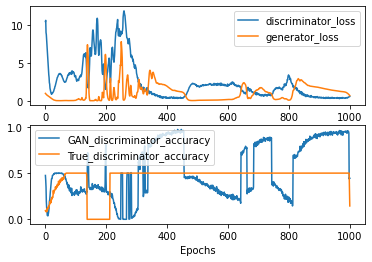

1875/1875 [==============================] - 4s 2ms/step


C:\Windows\Temp\ipykernel_7860\294214717.py:214: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distruex_final = pd.DataFrame(output_true_upsampled_x).append(pd.DataFrame(output_noise_x),ignore_index = True).to_numpy()
C:\Windows\Temp\ipykernel_7860\294214717.py:215: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distruey_final = pd.DataFrame(output_true_upsampled_y).append(pd.DataFrame(output_noise_y),ignore_index = True).to_numpy()


Final True Discriminant Accuracy: 0.555


In [9]:
disc2 = discriminatortrue(output_model_noise.shape[1])
disc = discriminator(output_model_true.shape[1])
gen = generator(output_model_true.shape[1])
gan = GAN(gen,disc)
train(gen,disc,disc2,gan,output_model_noise,output_model_true,n_epochs = 1000)

In [10]:
noise = np.random.randn(60000,output_model_noise.shape[1])
noise = np.expand_dims(noise,axis = 2)

1875/1875 [==============================] - 4s 2ms/step


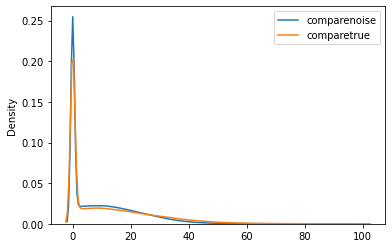

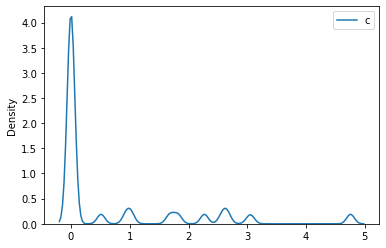

In [11]:
comparenoise = output_model_noise.flatten()
comparetrue = output_model_true.flatten()
comparefake = gen.predict(noise).flatten()
sns.kdeplot(comparenoise)
sns.kdeplot(comparetrue)
#sns.kdeplot(comparefake)
plt.legend(labels = ['comparenoise','comparetrue'])
plt.show()
sns.kdeplot(comparefake)
plt.legend(labels = 'comparefake')
plt.show()

In [12]:
comparenoise

array([ 0.       ,  3.9985962,  6.819223 , ...,  1.5422318,  0.       ,
       20.689201 ], dtype=float32)

In [13]:
from scipy.stats import ttest_rel

ttest_rel(comparetrue,comparefake)

Ttest_relResult(statistic=1053.6266336603267, pvalue=0.0)

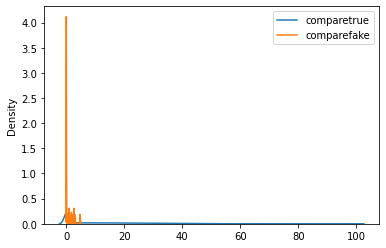

In [14]:
sns.kdeplot(comparetrue)
sns.kdeplot(comparefake)
plt.legend(labels = ['comparetrue','comparefake'])